In [12]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, math
from scipy.interpolate import interp1d

In [13]:
# read csv file from a game
df = pd.read_csv("2023_03_21_GW_Maryland.csv")
# sort data by the time of the pitch thrown, ascending
df = df.sort_values('Time')
# 0.01145833 miles is 60ft 6in
#0.003882576 miles is 20ft 6in , needed because pfxx, pfxz are measure 40ft from plate
df['TimeToPlate'] = df['RelSpeed'].apply(lambda x: 0.01145833 / x * 3600)
df['TimeTopf'] = df['RelSpeed'].apply(lambda x: 0.003882576 / x * 3600)

In [14]:
pitcher = 'Logan Ott'
pitcher_df = df.loc[df['Pitcher'] == pitcher]
pitch_dfs = pitcher_df.groupby('TaggedPitchType')
pitch_data = {}
for pitch in pitch_dfs:
    pitch_data[pitch[0]] = [pitch[1]['InducedVertBreak'].mean(), pitch[1]['pfxz'].mean(), pitch[1]['HorzBreak'].mean(), pitch[1]['pfxx'].mean(), pitch[1]['TimeToPlate'].mean(), pitch[1]['TimeTopf'].mean()]

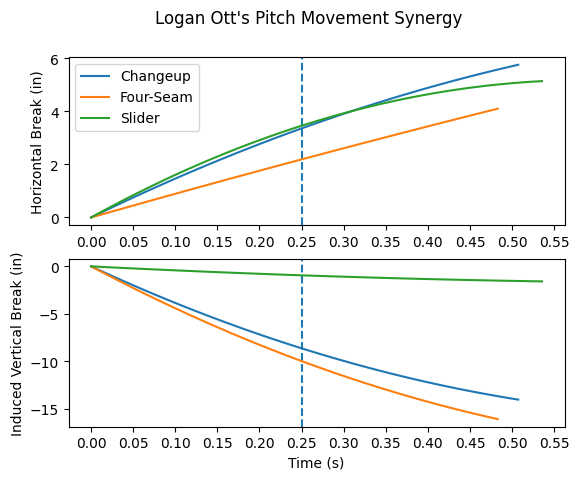

In [15]:
# create 2 subpluts, 1 for horizontal and 2 for vertical
fig, (ax1, ax2) = plt.subplots(2)
fig.suptitle(f'{pitcher}\'s Pitch Movement Synergy')
ax1.set(ylabel= 'Horizontal Break (in)', xticks= np.arange(0,0.6,0.05))
ax1.axvline(0.25, linestyle= '--')
ax2.set(ylabel= 'Induced Vertical Break (in)', xlabel= 'Time (s)', xticks= np.arange(0,0.6,0.05))
ax2.axvline(0.25, linestyle= '--')
for k in pitch_data:
    # 0, the time of 20ft 6in, time of 60ft 6in
    x_vals = [0, pitch_data[k][5], pitch_data[k][4]]
    
    # 0, total horz break at 20.5ft, total horz break at 60.5ft
    y_vals = [0, abs(pitch_data[k][2])-abs(pitch_data[k][3]), abs(pitch_data[k][2])]
    
    # Generate a spline interpolation function
    f = interp1d(x_vals, y_vals, kind='quadratic')
    pitch_data[k].append(f)

    # Evaluate the spline interpolation at 100 points between min(x_vals) and max(x_vals)
    x = np.linspace(min(x_vals), max(x_vals), 100)
    y = f(x)
    ax1.plot(x, y, label= k)
    # ax1.plot(x_vals, y_vals)
    
    # 0, total vert break at 20.5ft, total vert break at 60.5ft
    y_vals = [0, -abs(pitch_data[k][0]) + abs(pitch_data[k][1]), -abs(pitch_data[k][0])]
    
    # Generate a spline interpolation function
    f = interp1d(x_vals, y_vals, kind='quadratic')
    pitch_data[k].append(f)

    # Evaluate the spline interpolation at 100 points between min(x_vals) and max(x_vals)
    x = np.linspace(min(x_vals), max(x_vals), 100)
    y = f(x)
    ax2.plot(x, y, label= k)
    # ax2.plot(x_vals, y_vals)
    ax1.legend(loc='upper left')
plt.show()

In [16]:
# definig a function which takes in a pitch's plate location (in inches) and return what bucket the  pitch falls in.
# Assuming the center of the strike zone is at 0 side and 31 in height
def locToBucket(height, side):
    distToCenter = math.sqrt((height - 31)**2 + side**2)
    return int(distToCenter / 3) * 3    

In [17]:
# get rid of pitches that did not get their location recorded
df2 = df.dropna(subset= ['PlateLocHeight', 'PlateLocSide']).copy(deep= True)

# create a new column which has the location bucket of each pitch, which is the distance from the center of the strike zone
df2['locBuckets'] = df2.apply(lambda row: locToBucket(12 * row.PlateLocHeight, 12 * row.PlateLocSide), axis= 1)

# create a swing indicator column
df2['Swing?'] = df2['PitchCall'].apply(lambda x: x == 'StrikeSwinging' or x == 'InPlay' or x == 'Foul')

<Figure size 640x480 with 0 Axes>

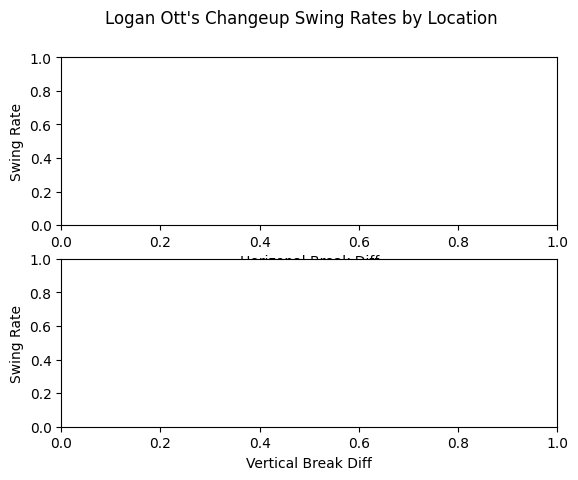

<Figure size 640x480 with 0 Axes>

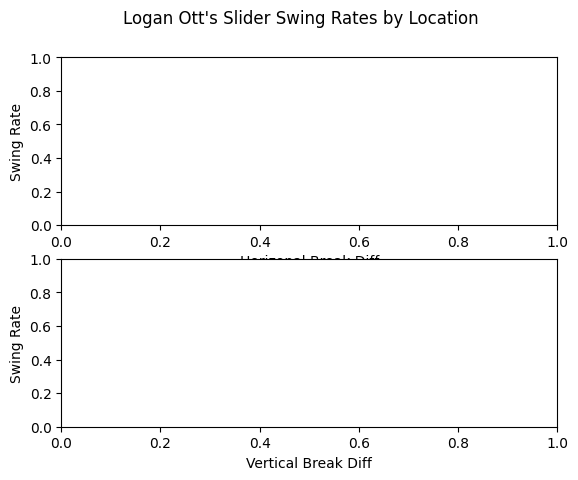

In [18]:
for k in pitch_data:
    if k != 'Four-Seam':
        # clear last pitch's graph
        plt.clf()
        
        # set up graph
        fig, (ax1, ax2) = plt.subplots(2)
        fig.suptitle(f'{pitcher}\'s {k} Swing Rates by Location')
        ax1.set(ylabel= 'Swing Rate', xlabel= 'Horizonal Break Diff')
        ax2.set(ylabel= 'Swing Rate', xlabel= 'Vertical Break Diff')
        
        
        plt.show()
